Generates PyPlot reward plots from stable_baselines TFEvents files

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import tensorflow.compat.v1 as tf

In [2]:
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
# replace with paths to tf-events files you want to convert
files = [
    "tf-events/DDPG_124/events.out.tfevents.1639254838.Tvastar.hsd1.co.comcast.net.24103.0",
    "tf-events/DDPG_126/events.out.tfevents.1639257585.Tvastar.hsd1.co.comcast.net.24542.0",
    "tf-events/DDPG_128/events.out.tfevents.1639263574.Tvastar.hsd1.co.comcast.net.25774.0"
]

In [4]:
files_dict = dict.fromkeys(files)
for f in files_dict:
    files_dict[f] = dict({'summary' : '', 'color' : None, 'label' : None, \
                          'stepsf' : [], 'lstf' : []})

In [5]:
for f in files:
    count = 0
    for summary in tf.train.summary_iterator(f):
        files_dict[f]['summary'] += str(summary) + "\n"
        count += 1
    print("%s %s events" % (f,count))

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
tf-events/DDPG_124/events.out.tfevents.1639254838.Tvastar.hsd1.co.comcast.net.24103.0 2278 events
tf-events/DDPG_126/events.out.tfevents.1639257585.Tvastar.hsd1.co.comcast.net.24542.0 2842 events
tf-events/DDPG_128/events.out.tfevents.1639263574.Tvastar.hsd1.co.comcast.net.25774.0 3016 events


In [10]:
# assign colors and labels
files_dict[files[0]]['color'] = 'g'
files_dict[files[0]]['label'] = 'Perturbed policy'

files_dict[files[1]]['color'] = 'b'
files_dict[files[1]]['label'] = 'Accurate policy'

files_dict[files[2]]['color'] = 'r'
files_dict[files[2]]['label'] = 'Imprecise policy'

In [11]:
def reward(contents):
    stringlist = [i for i in contents if not "wall_time" in i]
    stringlist = [i for i in stringlist if not "file_version" in i]
    stringlist = [i for i in stringlist if not "summary" in i]
    stringlist = [i for i in stringlist if not "step" in i]
    stringlist = [i for i in stringlist if not "}\n" in i]
    stringlist = [i for i in stringlist if not "value {\n" in i]
    stringlist_ = stringlist[::2]
    stringlist_value = stringlist[1::2]
        
    temp = defaultdict(list)
    for c, i in zip(stringlist_, stringlist_value):
        temp[c].append(i)

    lst_ = []
    for v,item in temp.items():
        if v == '    tag: "rollout/ep_rew_mean"': # change this to any other tag you want to plot
            for val in item:
                lst_.append(val.split()[1])
    lst_f = list(map(float, lst_))
    
    stringlist = [i for i in contents if "step" in i]
    step_list = []
    for int_ in stringlist:
        step_list.append(int_.split()[1])
    step_list_f = list(map(float, step_list))
    steps = list(set(step_list_f))
    
    return steps, lst_f

In [12]:
for f in files:
    files_dict[f]['stepsf'], files_dict[f]['lstf'] = reward(files_dict[f]['summary'].split("\n"))

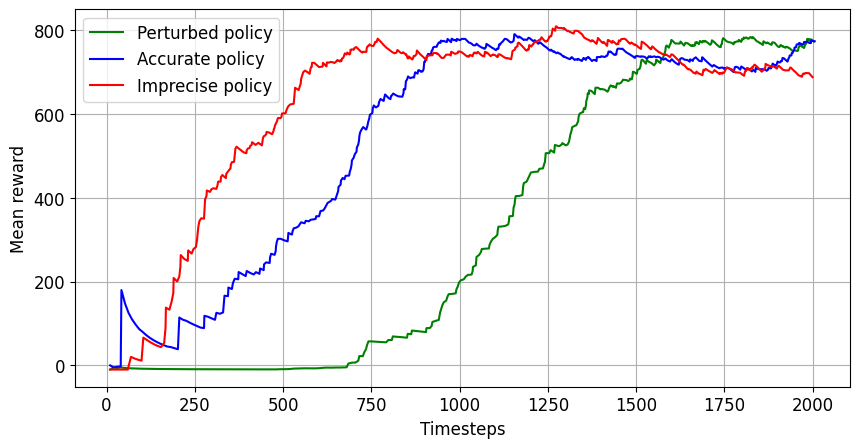

In [13]:
font = {'size'   : 12}

plt.rc('font', **font)

nrows, ncols = 1, 1
ratio, scale = 0.5, 10
dpi = 100
figsize =(ncols*scale, nrows*scale*ratio)
fig, axes = plt.subplots(nrows, ncols, figsize= figsize, dpi= dpi)
axes.grid(True)
axes = np.array(axes).reshape((nrows, ncols))

ax = axes[0, 0]

for f in files:
    ax.plot(files_dict[f]['stepsf'], files_dict[f]['lstf'], \
            c=files_dict[f]['color'], label=files_dict[f]['label'])

ax.legend()
ax.set_xlabel("Timesteps")
ax.set_ylabel("Mean reward")
ax.figure.savefig("reward.png")